<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Geospatial-Analysis" data-toc-modified-id="Geospatial-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Geospatial Analysis</a></span><ul class="toc-item"><li><span><a href="#Neighbourhood-Groups" data-toc-modified-id="Neighbourhood-Groups-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Neighbourhood Groups</a></span></li><li><span><a href="#Listings" data-toc-modified-id="Listings-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Listings</a></span><ul class="toc-item"><li><span><a href="#Concentration" data-toc-modified-id="Concentration-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Concentration</a></span></li></ul></li><li><span><a href="#Listings-timeseries" data-toc-modified-id="Listings-timeseries-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Listings timeseries</a></span></li></ul></li><li><span><a href="#Adjectives-map" data-toc-modified-id="Adjectives-map-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Adjectives map</a></span></li><li><span><a href="#Calendar-Availability" data-toc-modified-id="Calendar-Availability-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calendar Availability</a></span></li></ul></div>

### Geospatial Analysis

In [2]:
import folium 
from folium import plugins
from folium.plugins import HeatMap
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import branca.colormap as branca_folium_cm
from branca.element import Template
import json
import h3
from shapely.geometry import Polygon
from branca.utilities import color_brewer

In [3]:
GEO_JSON = "data/neighbourhoods.geojson"

#### Neighbourhood Groups

Simple map showing the neighbourhood group and set the context

In [4]:
m = folium.Map(
    tiles=None,
    location=[40.7769, -73.8740], # NYC
    zoom_start=10,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
    doubleClickZoom=False,
    minZoom=10, maxZoom=10,
    maxBounds=[
        [40.7769, -73.8740],
        [40.7769, -73.8740]
    ]
)

# use black background
folium.TileLayer(
    attr=" ",
    tiles="https://{s}.basemaps.cartocdn.com/rastertiles/dark_nolabels/{z}/{x}/{y}.png",
    overlay=False,
    control=False
).add_to(m)

# Color map
cmap = {
    ng: matplotlib.colors.rgb2hex(matplotlib.cm.get_cmap('Set2')(i)[:3])
    for i, ng in enumerate([
        'Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'
    ])
}

def style_function(feature):
    neighbourhood_group = feature["properties"]["neighbourhood_group"]
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': cmap.get(neighbourhood_group, "#CCC")
    }

folium.GeoJson(
    GEO_JSON,
    name='neighbourhoods',
    style_function=style_function
).add_to(m)

# Adding labels

label_format = '<div style="font-size:20pt; font-family: Arial, Helvetica, sans-serif; color:#eee">{}</div>'.format

folium.map.Marker(
    [40.7469, -73.8750],
    icon=folium.DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html=label_format("Queens"),
    )
).add_to(m)

folium.map.Marker(
    [40.8669, -73.9190],
    icon=folium.DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html=label_format("Bronx"),
    )
).add_to(m)

folium.map.Marker(
    [40.6669, -74.0190],
    icon=folium.DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html=label_format("Brooklyn"),
    )
).add_to(m)

folium.map.Marker(
    [40.7969, -74.1750],
    icon=folium.DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html=label_format("Manhattan"),
    )
).add_to(m)

folium.map.Marker(
    [40.6369, -74.200],
    icon=folium.DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html=label_format("Staten Island"),
    )
).add_to(m)

m.save("vis/neighbourhood_groups.html")

![nbg](img/neighbourhood_groups.png)

#### Listings

All the maps below include multiple layers to allow the users to select what to see (control at the bottom left of the map). The idea is to avoid visual clutter but still be able to present the information to the user on request.

In [5]:
touristic_poi = {
    "Statue of Liberty" : [40.689247,-74.044502],
    "Staten Island Ferry" : [40.6441, -74.0725],
    "Empire State Building" : [40.748817,-73.985428],
    "Metropolitan Museum" : [40.778965,-73.985428],
    "Midtown Manhattan" : [40.754932,-73.984016],
    "Grand Central Terminal" : [40.752655, -73.977295],
    "Central Park" : [40.785091, -73.968285],
    "Rockefeller Center" : [40.758740, -73.978674],
    "Brooklyn Bridge" : [40.706001, -73.997002],
    "Theater District" : [40.758896, -73.985130],
    "Times Square" : [40.758896, -73.985130],
    "World Trade Center" : [40.712742, -74.013382],
    "Greenwich Village" : [40.730522, -74.002205],
    "Madison Square Garden" : [40.750298, -73.993324],
    "Chelsea Market" : [40.742352, -74.006210],
    "Carnegie Hall" : [40.764988, -73.979897],
    "Little Italy" : [40.719330, -73.997307],
    "Manhattan Bridge" : [40.707496, -73.990774],
    "Meatpacking District" : [40.7410, -74.0076],
    "Guggenheim Museum" : [40.782978, -73.959030],
}

In [6]:
full_listings = pd.read_csv("data/listings.csv")
# full_listings = pd.read_pickle("listings_clean.pkl")

##### Concentration

We now want to show the number of AirBnB listings in New York City.

In [7]:
listings = full_listings[["id", "latitude", "longitude"]]
listings = listings.dropna()

In [8]:
m = folium.Map(
    tiles=None,
    location=[40.7169, -73.9940],
    zoom_start=11,
    min_zoom=10,
    scrollWheelZoom=False,
    doubleClickZoom=False,
)

folium.TileLayer(
    attr=" ",
    tiles="https://{s}.basemaps.cartocdn.com/rastertiles/dark_nolabels/{z}/{x}/{y}.png",
    overlay=False,
    control=False
).add_to(m)

for i, l in listings.iterrows():
    folium.CircleMarker(
        location=[l["latitude"], l["longitude"]],
        radius=1,
        fill=True,
        fill_color='#3186cc',
        stroke=False,
        fill_opacity=0.1
    ).add_to(m)

locations = []
popups = []
icons = []
for n, (lat, lon) in touristic_poi.items():
    locations.append([lat, lon])
    popups.append(n)
    icons.append(folium.Icon(color="green", icon_color="white"))

h = folium.FeatureGroup(name='POI', show=False)
h.add_child(plugins.MarkerCluster(
    locations=locations, popups=popups, icons=icons,
    showCoverageOnHover=False
))
m.add_child(h)

folium.LayerControl(position='bottomleft').add_to(m)

m.save("vis/listings_2020.html")

![nbg](img/listings_2020.png)

#### Listings timeseries

Time evolutive map, showing the evolution of the number of AirBnB listings throughout the years

In [31]:
listings_ts = pd.read_csv(
    "data/TA3.csv", 
    parse_dates=["month_year", "first_month", "last_month", "last_review"]
)

To reduce the number of points displayed on the map (both for performance and to avoid visual clutter), we group them by geographical region. We use the library `h3` developed by Uber.

In [33]:
def _lat_lon_to_h3(row):
    return h3.geo_to_h3(
      row["latitude"], row["longitude"], 9
    )
listings_ts["h3"] = listings_ts.apply(_lat_lon_to_h3, axis=1)

In [34]:
listings_counts = listings_ts.groupby(["h3", pd.Grouper(key="month_year", freq="6M")])["id"].count().reset_index()

Creation of the geojson features.

In [35]:
def create_listings_counts_ts_geojson_features(df):
    features = []
    min_val, max_val = df["id"].min()*0.9, df["id"].max()*2
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': Polygon(h3.h3_to_geo_boundary(row["h3"], True)).__geo_interface__,
            'properties': {
                'time': row['month_year'].date().__str__(),
                'style': {
                    'color':'#3186cc',
                    'opacity': 0,
                    'fillColor': '#3186cc',
                    'fillOpacity': (row["id"] - min_val) / (max_val - min_val)
                },
            }
        }
        features.append(feature)
    return features

In [36]:
listings_counts_ts_features = create_listings_counts_ts_geojson_features(listings_counts)

In [37]:
json.dump(
    {
        'type': 'FeatureCollection',
        'features': listings_counts_ts_features
    }, open("listings_counts_ts_features.json", "w")
)

In [38]:
m = folium.Map(
    tiles=None,
    location=[40.7169, -73.9940],
    zoom_start=11,
    min_zoom=10,
    doubleClickZoom=False,
    scrollWheelZoom=False,
)

folium.TileLayer(
    attr=" ",
    tiles="https://{s}.basemaps.cartocdn.com/rastertiles/dark_nolabels/{z}/{x}/{y}.png",
    control=False
).add_to(m)

ts_gj = plugins.TimestampedGeoJson(
    open('listings_counts_ts_features.json'), 
    period='P6M', 
    add_last_point=True,
    auto_play=False, 
    loop=False, 
    max_speed=5,  
    date_options='YYYY/MM', 
    time_slider_drag_update=True
).add_to(m)

locations = []
popups = []
icons = []
for n, (lat, lon) in touristic_poi.items():
    locations.append([lat, lon])
    popups.append(n)
    icons.append(folium.Icon(color="green", icon_color="white"))

h = folium.FeatureGroup(name='POI')
h.add_child(plugins.MarkerCluster(
    locations=locations, popups=popups, icons=icons,
    showCoverageOnHover=False
))
m.add_child(h)

folium.LayerControl(position='bottomleft').add_to(m)

# saving to a separate file for performance
m.save("vis/listings_counts_ts.html")

![ListingsTS](img/listings_ts_small.gif)

### Adjectives map

Here, we create a map of NYC composed by the adjectives present in the reviews for each Neighbourhood group.

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
reviews = pd.read_pickle("reviews_transformed.pkl")
full_listings = pd.read_csv("data/listings.csv")

/Users/N547113/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
listing_neighbourhood = full_listings[["id", "neighbourhood_group_cleansed"]]
listing_reviews_adj = reviews[["listing_id", "adjectives"]]

In [4]:
reviews_neighbourhood = pd.merge(listing_reviews_adj, listing_neighbourhood, left_on="listing_id", right_on="id")

In [5]:
reviews_neighbourhood = reviews_neighbourhood[["neighbourhood_group_cleansed", "adjectives"]]

In [6]:
# this is required to allow the image superposition
def convert_white_to_transparent(img):
    img = img.convert("RGBA")
    datas = img.getdata()

    newData = []
    for item in datas:
        if item[0] > 250 and item[1] > 250 and item[2] > 250:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    img.putdata(newData)
    return img

def convert_black_to_transparent(img):
    img = img.convert("RGBA")
    datas = img.getdata()

    newData = []
    for item in datas:
        if item[0] < 5 and item[1] < 5 and item[2] < 5:
            newData.append((0, 0, 0, 0))
        else:
            newData.append(item)

    img.putdata(newData)
    return img

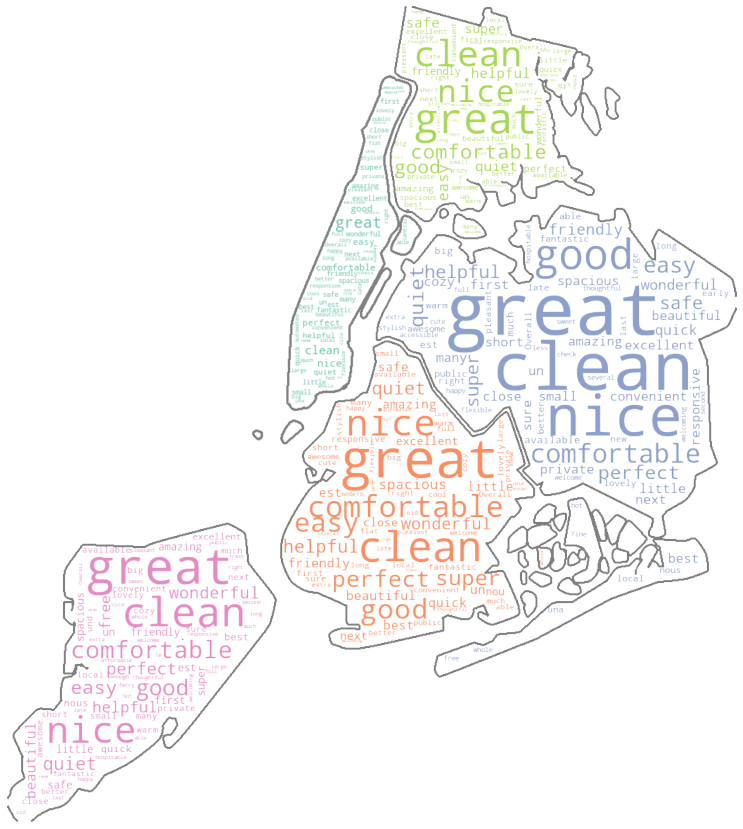

In [7]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.axis("off")

cmap = plt.cm.get_cmap('Set2')

for i, n in enumerate(["Manhattan", "Brooklyn", "Queens", "Staten Island", "Bronx",]):

    r_n = reviews_neighbourhood[
        reviews_neighbourhood["neighbourhood_group_cleansed"] == n
    ]

    text = " ".join([t for tokens in r_n.loc[~r_n["adjectives"].isnull(), "adjectives"].values for t in tokens])
    mask = np.array(convert_white_to_transparent(Image.open(f"img/{n.lower().replace(' ', '_')}.jpg")))
    
    wc = WordCloud(
        background_color="white", max_words=75, contour_width=2, contour_color='gray',
        mask=mask, include_numbers=False, collocations=False,
        color_func=lambda *args, **kwargs: cmap(i, bytes=True), random_state=123, 
    )

    wc.generate(text)
    if i != 0:
        wc = convert_white_to_transparent(wc.to_image())
    ax.imshow(wc, interpolation='bilinear')
    
fig.savefig("vis/wordmap.png")

### Calendar Availability

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import nltk
import altair as alt
import calmap

Here we show the availability by day. We use a calendar view to really capture the seasonal trend. It then becomes easy to compare different years, months, weeks. We use a diverging colormap to clearly distinguish between high availability and low availability.

In [2]:
## !!! Takes a long time, uncomment to refresh !!!

## Joining all the calendars files together
# paths = []
# for y in [18, 19, 20]:
#     for m in range(1, 13):
#         p = f"data/calendar/calendar_{m:02d}{y}.csv"
#         if os.path.exists(p):
#             paths.append(p)

# paths = reversed(paths)

# dfs = []

# for i, p in enumerate(paths):
#     d = pd.read_csv(p, true_values="t", false_values="f", parse_dates=["date"])
#     if i > 0:
#         min_date = dfs[-1]["date"].min()
#         d = d[d["date"] < min_date]
#     dfs.append(d)
# 
# all_df = pd.concat(dfs, sort=False)
# all_df = all_df[["listing_id", "date", "available", "price"]]
# all_df["price"] = all_df["price"].str.replace("$", "").str.replace(",", "").astype(float)
# all_df.set_index("date", inplace=True)
# all_df.to_pickle("calendars.pkl")

In [3]:
# all_df = pd.read_pickle("calendars.pkl")

In [4]:
available_count_by_day = all_df[all_df["available"] == True].groupby(pd.Grouper(freq="d"))["listing_id"].count()

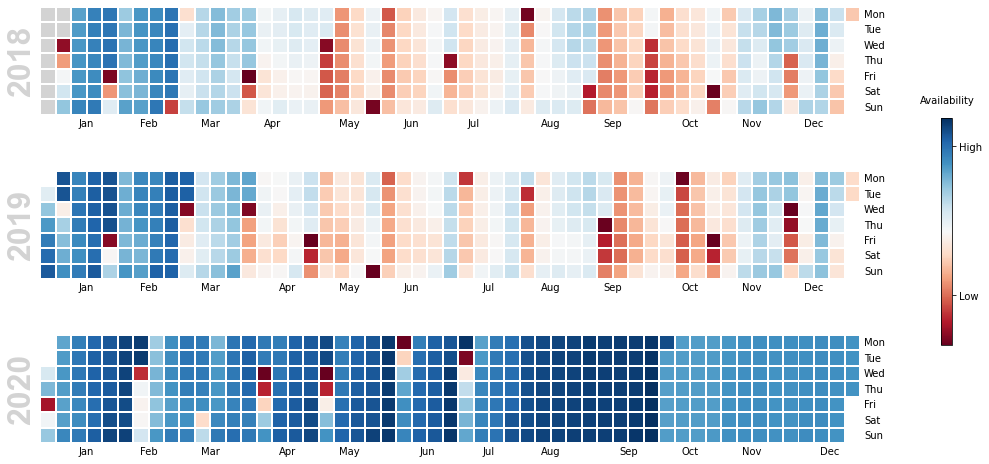

In [5]:
fig, axs = calmap.calendarplot(
    available_count_by_day.loc[:'2020-12-31'], 
    fig_kws={"figsize": (15, 7)},
    cmap='RdBu',
    fillcolor='lightgray',
)

fig.subplots_adjust(right=0.8)
cbar = fig.colorbar(
    axs[0].get_children()[1], 
    cax=fig.add_axes([0.875, 0.275, 0.01, 0.45]), 
    orientation='vertical',
    ticks=[5000.0, 20000.0],
    aspect=1
)
cbar.ax.set_yticklabels(['Low', 'High'])
cbar.set_label('Availability', labelpad=-35, y=1.1, rotation=0)

fig.savefig("vis/availability_calendar.png")